In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from tqdm import trange, tqdm

from itertools import product
import sys
import os
sys.path.append('../')
from CAS import *

import ECG.ecg_sknetwork as ecg_sknetwork
import ecg_igraph as ecg_igraph

In [2]:
def compute_edge_weights(G, cas, clusters, combine_function="min", normalize=True):
        source_to_target = np.empty(G.ecount())
        target_to_source = np.empty(G.ecount())
        for i, e in enumerate(G.es):
                target_clusters = clusters.indices[clusters.indptr[e.target]:clusters.indptr[e.target+1]]
                if len(target_clusters) == 0:
                        source_to_target[i] = 0
                else:
                        source_to_target[i] = np.max([cas[e.source, target_cluster] for target_cluster in target_clusters])

                source_clusters = clusters.indices[clusters.indptr[e.source]:clusters.indptr[e.source+1]]
                if len(source_clusters) == 0:
                        target_to_source[i] = 0
                else:
                        target_to_source[i] = np.max([cas[e.source, source_cluster] for source_cluster in source_clusters])

        if combine_function=="min":
                weights = np.minimum(source_to_target, target_to_source)
        elif combine_function=="prod":
               weights = source_to_target * target_to_source
        elif combine_function=="mean":
                weights = (source_to_target + target_to_source)/2
        else:
               raise ValueError(f"combine_function must be one of min, prod, mean. Got {combine_function}")
        
        if normalize:
               return weights / (np.max(weights) - np.min(weights))
        return weights


def cas_edge_weights(G, clusters, combine_function="min", normalize=True):
        graph_matrix = G.get_adjacency_sparse()
        ief, beta, c, p, degs = CAS(graph_matrix, clusters)

        ief_weights = compute_edge_weights(G, ief, clusters, combine_function=combine_function, normalize=normalize)
        beta_weights = compute_edge_weights(G, beta, clusters, combine_function=combine_function, normalize=normalize)
        c_weights = compute_edge_weights(G, c, clusters, combine_function=combine_function, normalize=normalize)
        p_weights = compute_edge_weights(G, p, clusters, combine_function=combine_function, normalize=normalize)

        ecg_weights = compute_edge_weights(G, clusters, clusters, combine_function=combine_function, normalize=False)
        
        return ief_weights, beta_weights, c_weights, p_weights, ecg_weights


def ensemble_cas_edge_weights(G, ens_size=16, combine_function="min", normalize=True, clustering_method="first_louvain", resolution=0.1):
        ief_weights = np.zeros(G.ecount())
        beta_weights = np.zeros(G.ecount())
        c_weights = np.zeros(G.ecount())
        p_weights = np.zeros(G.ecount())
        ecg_weights = np.zeros(G.ecount())

        for _ in range(ens_size):
                permutation = np.random.permutation(G.vcount())
                g = G.permute_vertices(permutation)
                if clustering_method == "leiden":
                        clustering = np.array(g.community_leiden(resolution=resolution).membership)
                elif clustering_method == "louvain":
                        clustering = np.array(g.community_louvain(resolution=resolution).membership)
                elif clustering_method == "first_louvain":
                        clustering = np.array(g.community_multilevel(return_levels=True)[0].membership)
                else:
                        raise ValueError(f"clustering_method expected one of leiden, louvain, or first_louvain. Got {clustering_method}")
                
                clustering = partition2sparse(clustering)
                ief, beta, c, p, ecg = cas_edge_weights(g, clustering, combine_function=combine_function, normalize=normalize)

                ief_weights += ief
                beta_weights += beta
                c_weights += c
                p_weights += p
                ecg_weights += ecg

        return ief_weights/ens_size, beta_weights/ens_size, c_weights/ens_size, p_weights/ens_size, ecg_weights/ens_size


def cluster_edges(G, edge_weights, min_weight=0.05, twocore=True, final="leiden", resolution=1.0):
        if min_weight > 0:
                edge_weights = (1-min_weight) * edge_weights + min_weight
        
        if twocore:
                core = G.shell_index()
                ecore = np.array([min(core[e.source],core[e.target]) for e in G.es])
                edge_weights[ecore == 1] = min_weight

        if final == "leiden":
                return G.community_leiden(weights=edge_weights, objective_function='modularity', resolution=resolution)
        elif final == "louvain":
                return G.community_multilevel(weights=edge_weights)
        else:
                raise ValueError(f"final expected one of leiden or louvain. Got {final}")


def outlier_scores(G, edge_weights, clustering):
        degs = np.array(G.degree())
        good = np.zeros(G.vcount())
        bad = np.zeros(G.vcount())
        for i, e in enumerate(G.es):
                if clustering[e.source] == clustering[e.target]:
                      good[e.source] += edge_weights[i]
                      good[e.target] += edge_weights[i]
                else:
                      bad[e.source] += edge_weights[i]
                      bad[e.target] += edge_weights[i]       
        
        overall = (degs - bad - good)/degs
        community = bad/(bad + good)
        return overall, community

In [3]:
def community_ecg(self, weights=None, ens_size = 16, min_weight = 0.05, 
                  final='louvain', resolution=1.0, refuse_score=False):
    """
    Stable ensemble-based graph clustering;
    the ensemble consists of single-level randomized Louvain; 
    each member of the ensemble gets a "vote" to determine if the edges 
    are intra-community or not;
    the votes are aggregated into ECG edge-weights in range [0,1]; 
    a final (full depth) Louvain is run using those edge weights;
    
    Parameters
    ----------
    self: graph of type 'igraph.Graph'
      Graph to define the partition on.
    weights: list of double, optional 
      the edge weights
    ens_size: int, optional
      the size of the ensemble of single-level Louvain
    min_weight: double in range [0,1], optional
      the ECG edge weight for edges with zero votes from the ensemble
    final: 'louvain' (default) or 'leiden'
      the algorithm to run on the final re-weighted graph
    resolution: positive float, optional
      resolution parameter; larger values favors smaller communities
      
    Returns
    -------
    partition
      The final partition, of type 'igraph.clustering.VertexClustering'
    partition.W
      The ECG edge weights
    partition.CSI
      The community strength index
    partition.original_modularity
      The modularity with respect to the original edge weights

    Notes
    -----
    The ECG edge weight function is defined as:
      
      min_weight + ( 1 - min_weight ) x (#votes_in_ensemble) / ens_size
      
    Edges outside the 2-core are assigned 'min_weight'.
    
    Examples
    --------
    >>> g = igraph.Graph.Famous('Zachary')
    >>> part = g.community_ecg(ens_size=25, min_weight = .1)
    >>> print(part.CSI)
    
    Reference
    ---------
    Valérie Poulin and François Théberge, "Ensemble clustering for graphs: comparisons and applications", Appl Netw Sci 4, 51 (2019). 
    https://doi.org/10.1007/s41109-019-0162-z
    """
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l1 = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l1[p[x.tuple[0]]]==l1[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    if final=='leiden':
        part = self.community_leiden(weights=w, objective_function='modularity', resolution=resolution)
    else:
        part = self.community_multilevel(weights=w, resolution=resolution)
    part.W = W
    part.CSI = 1-2*np.sum([min(1-i,i) for i in W])/len(W)
    part._modularity_params['weights'] = weights
    part.recalculate_modularity()
    
    ## experimental - "refuse to cluster" scores
    if refuse_score:
        self.vs['_deg'] = self.degree()
        self.es['_W'] = part.W
        self.vs['_ecg'] = part.membership
        for v in self.vs:
            scr = 0
            my_comm = v['_ecg']
            good = 0
            bad = 0
            for e in v.incident():
                scr += e['_W']
                if self.vs[e.source]['_ecg'] == self.vs[e.target]['_ecg']:
                    good += e['_W']
                else:
                    bad += e['_W']
            v['_overall'] = ((v['_deg']-scr)/v['_deg'])
            v['_community'] = (bad/(bad+good))        
        part.refuse_overall = self.vs['_overall']
        part.refuse_community = self.vs['_community']
        del(self.vs['_deg'])
        del(self.es['_W'])
        del(self.vs['_ecg'])
        del(self.vs['_overall'])
        del(self.vs['_community'])            
    ## end experimental scores
    
    return part

ig.Graph.community_ecg = community_ecg

## Code to generate ABCD-o graphs (currently requires julia)

In [4]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/home/rdewolfe/research/ABCDGraphGenerator.jl/utils/'
julia = '/home/rdewolfe/.juliaup/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    g = ig.Graph.Read_Ncol(fn_net,directed=False)
    c = np.loadtxt(fn_comm,dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    g.vs['gt'] = gt
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g

## Test if CAS scores can weight edges well using ground truth communities

100%|██████████| 5/5 [00:55<00:00, 11.09s/it]


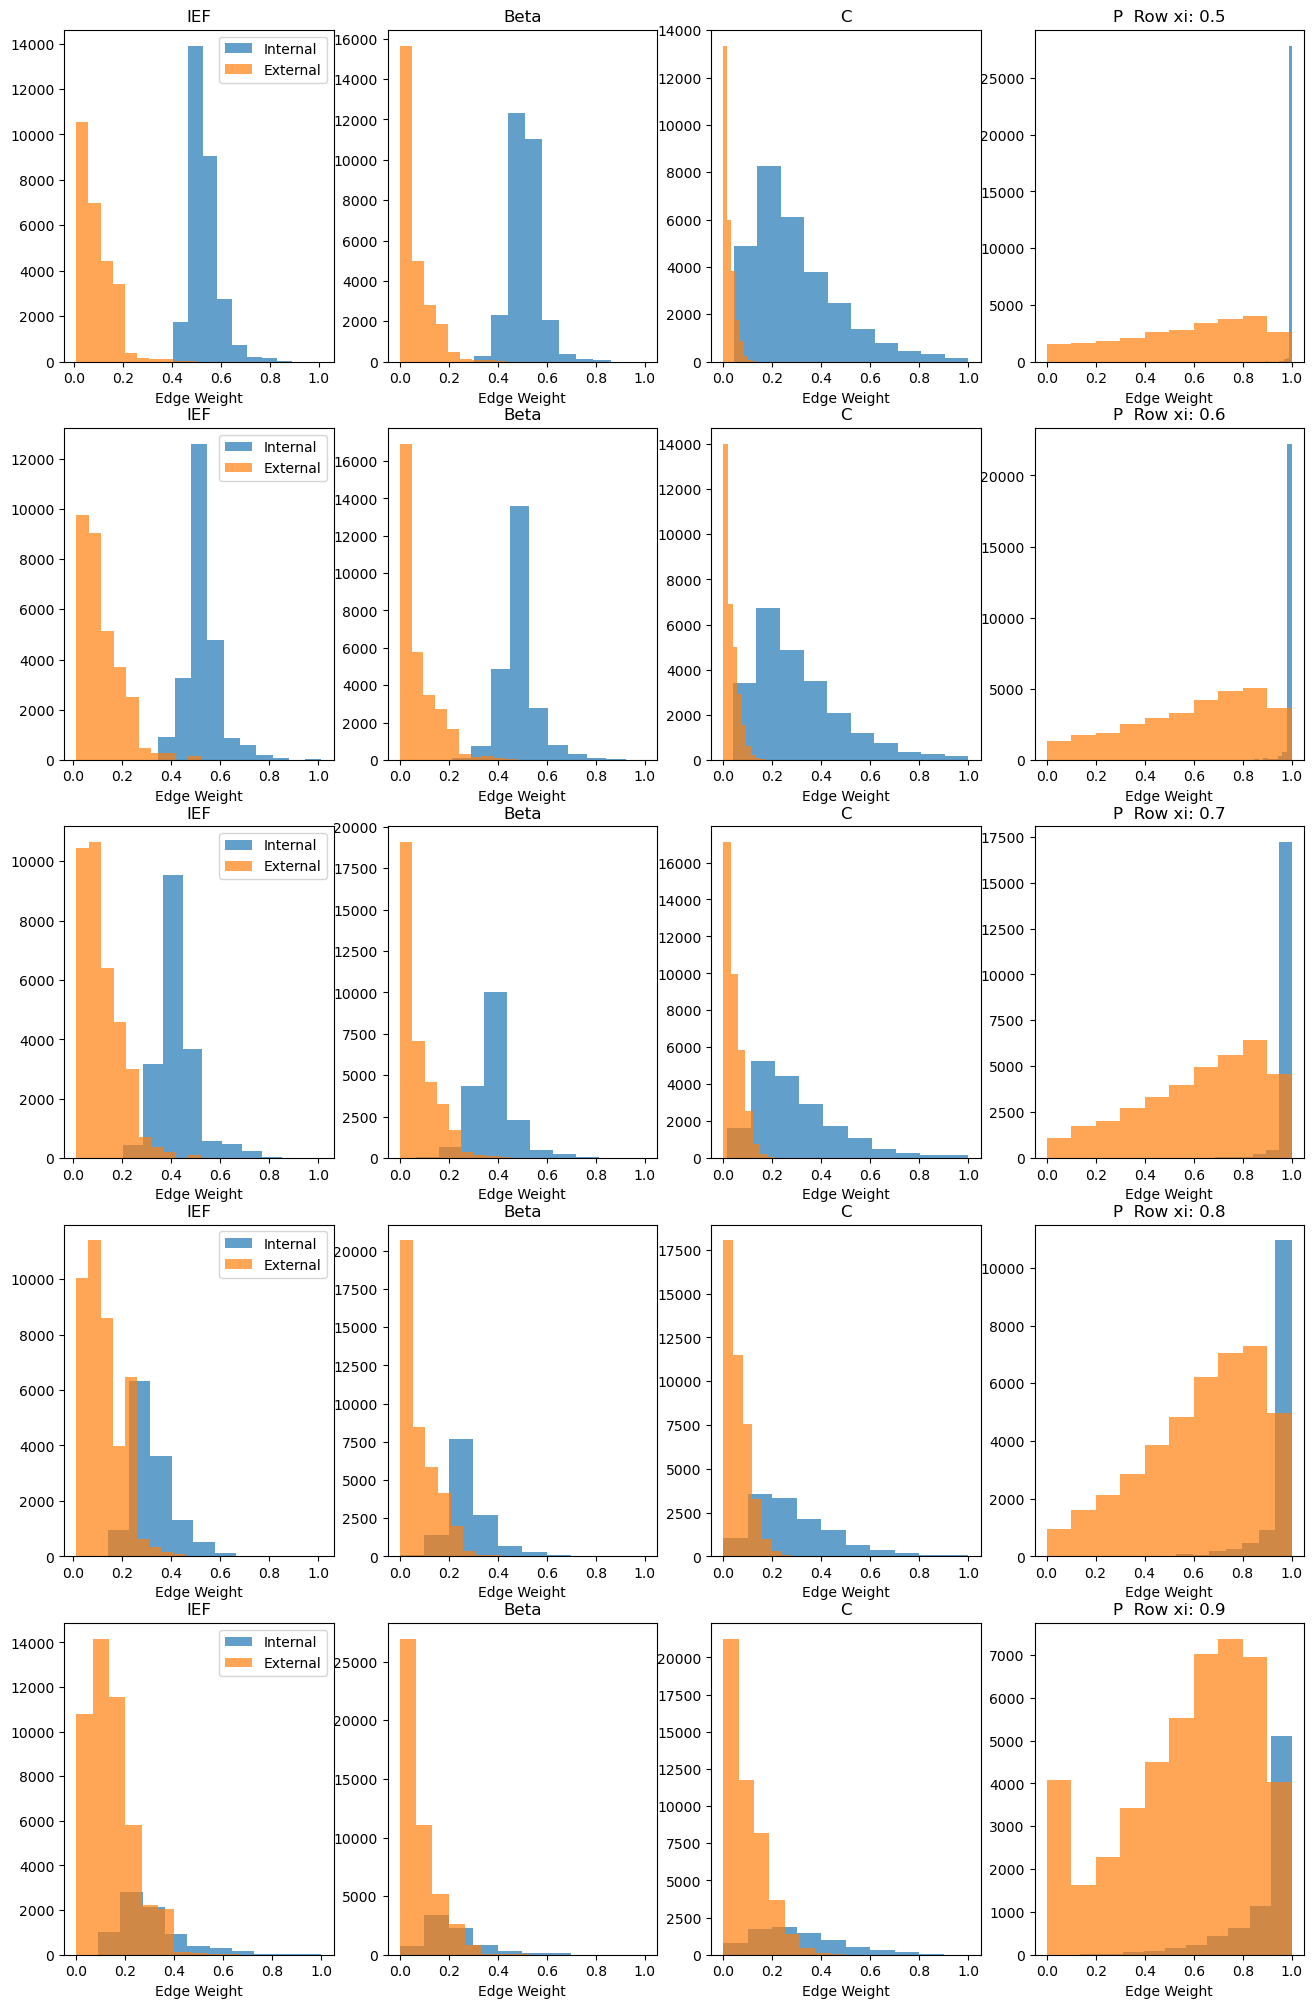

In [ ]:
## first with "mid-size" graphs
num_nodes = 10000
num_out = 0
delta = 5
min_comm = 100
alpha = 1


XIs = [.5, .6, .7, .8, .9]
fig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    gt = partition2sparse(g.vs["gt"])
    ief, beta, c, p, ecg = cas_edge_weights(g, gt)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.7)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel(r'$\xi$ ='+str(xi))

    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 1].hist(beta[is_internal == False], label="External", alpha=0.7)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("Beta")

    axs[i, 2].hist(c[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 2].hist(c[is_internal == False], label="External", alpha=0.7)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title("C")

    axs[i, 3].hist(p[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 3].hist(p[is_internal == False], label="External", alpha=0.7)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"P")


100%|██████████| 9/9 [01:36<00:00, 10.75s/it]


Text(0.5, 0.98, 'CAS-ECG ground truth ROC curves')

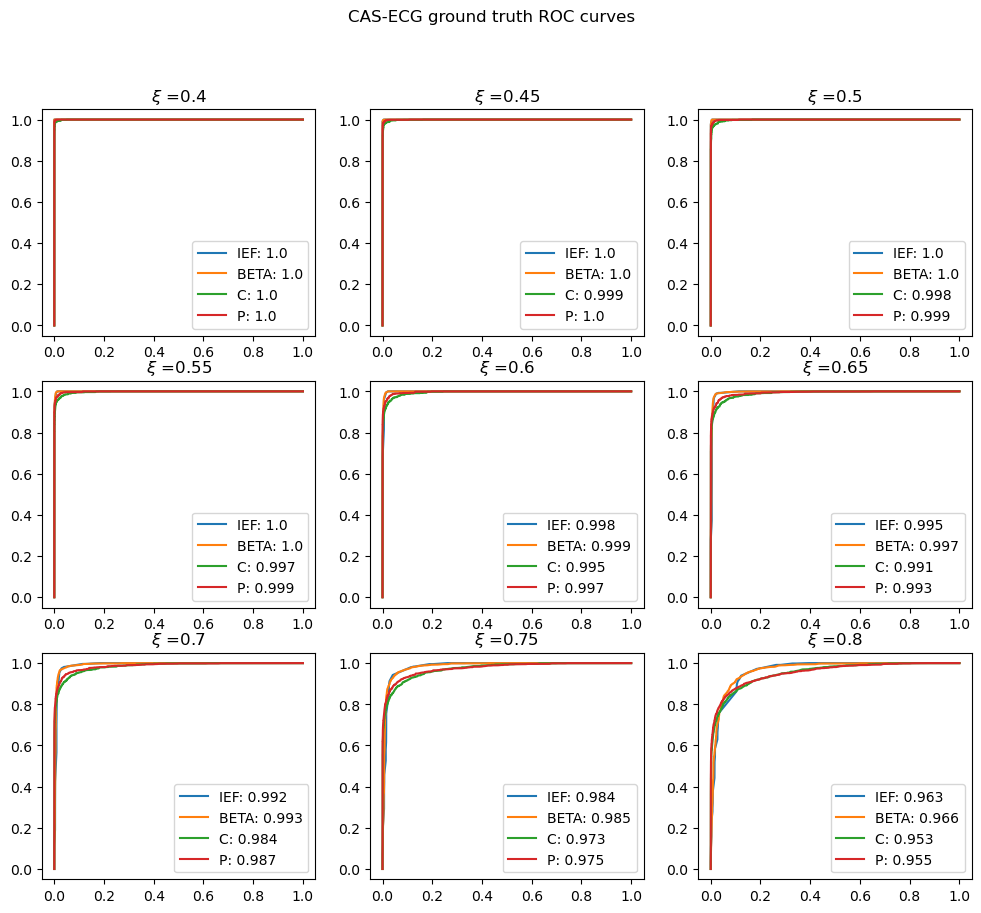

In [ ]:
# AUCROC curves for edge weight predicting is-internal
XIs = [.5, .55, .6, .65, .7, .75, .8, .85, 9]
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in trange(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    gt = partition2sparse(g.vs["gt"])
    ief, beta, c, p, ecg = cas_edge_weights(g, gt)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    fpr, tpr, thresholds = roc_curve(is_internal, ief, pos_label=1)
    plt.plot(fpr, tpr, label='IEF: '+str(round(AUC(is_internal, ief),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, beta, pos_label=1)
    plt.plot(fpr, tpr, label='BETA: '+str(round(AUC(is_internal, beta),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, c, pos_label=1)
    plt.plot(fpr, tpr, label='C: '+str(round(AUC(is_internal, c),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, p, pos_label=1)
    plt.plot(fpr, tpr, label='P: '+str(round(AUC(is_internal, p),3)))

    plt.title(r'$\xi$ ='+str(xi))
    plt.legend()
    

plt.suptitle("CAS-ECG ground truth ROC curves")

## Test if the Ensemble edge-weights can perform similarily

100%|██████████| 5/5 [09:54<00:00, 118.85s/it]


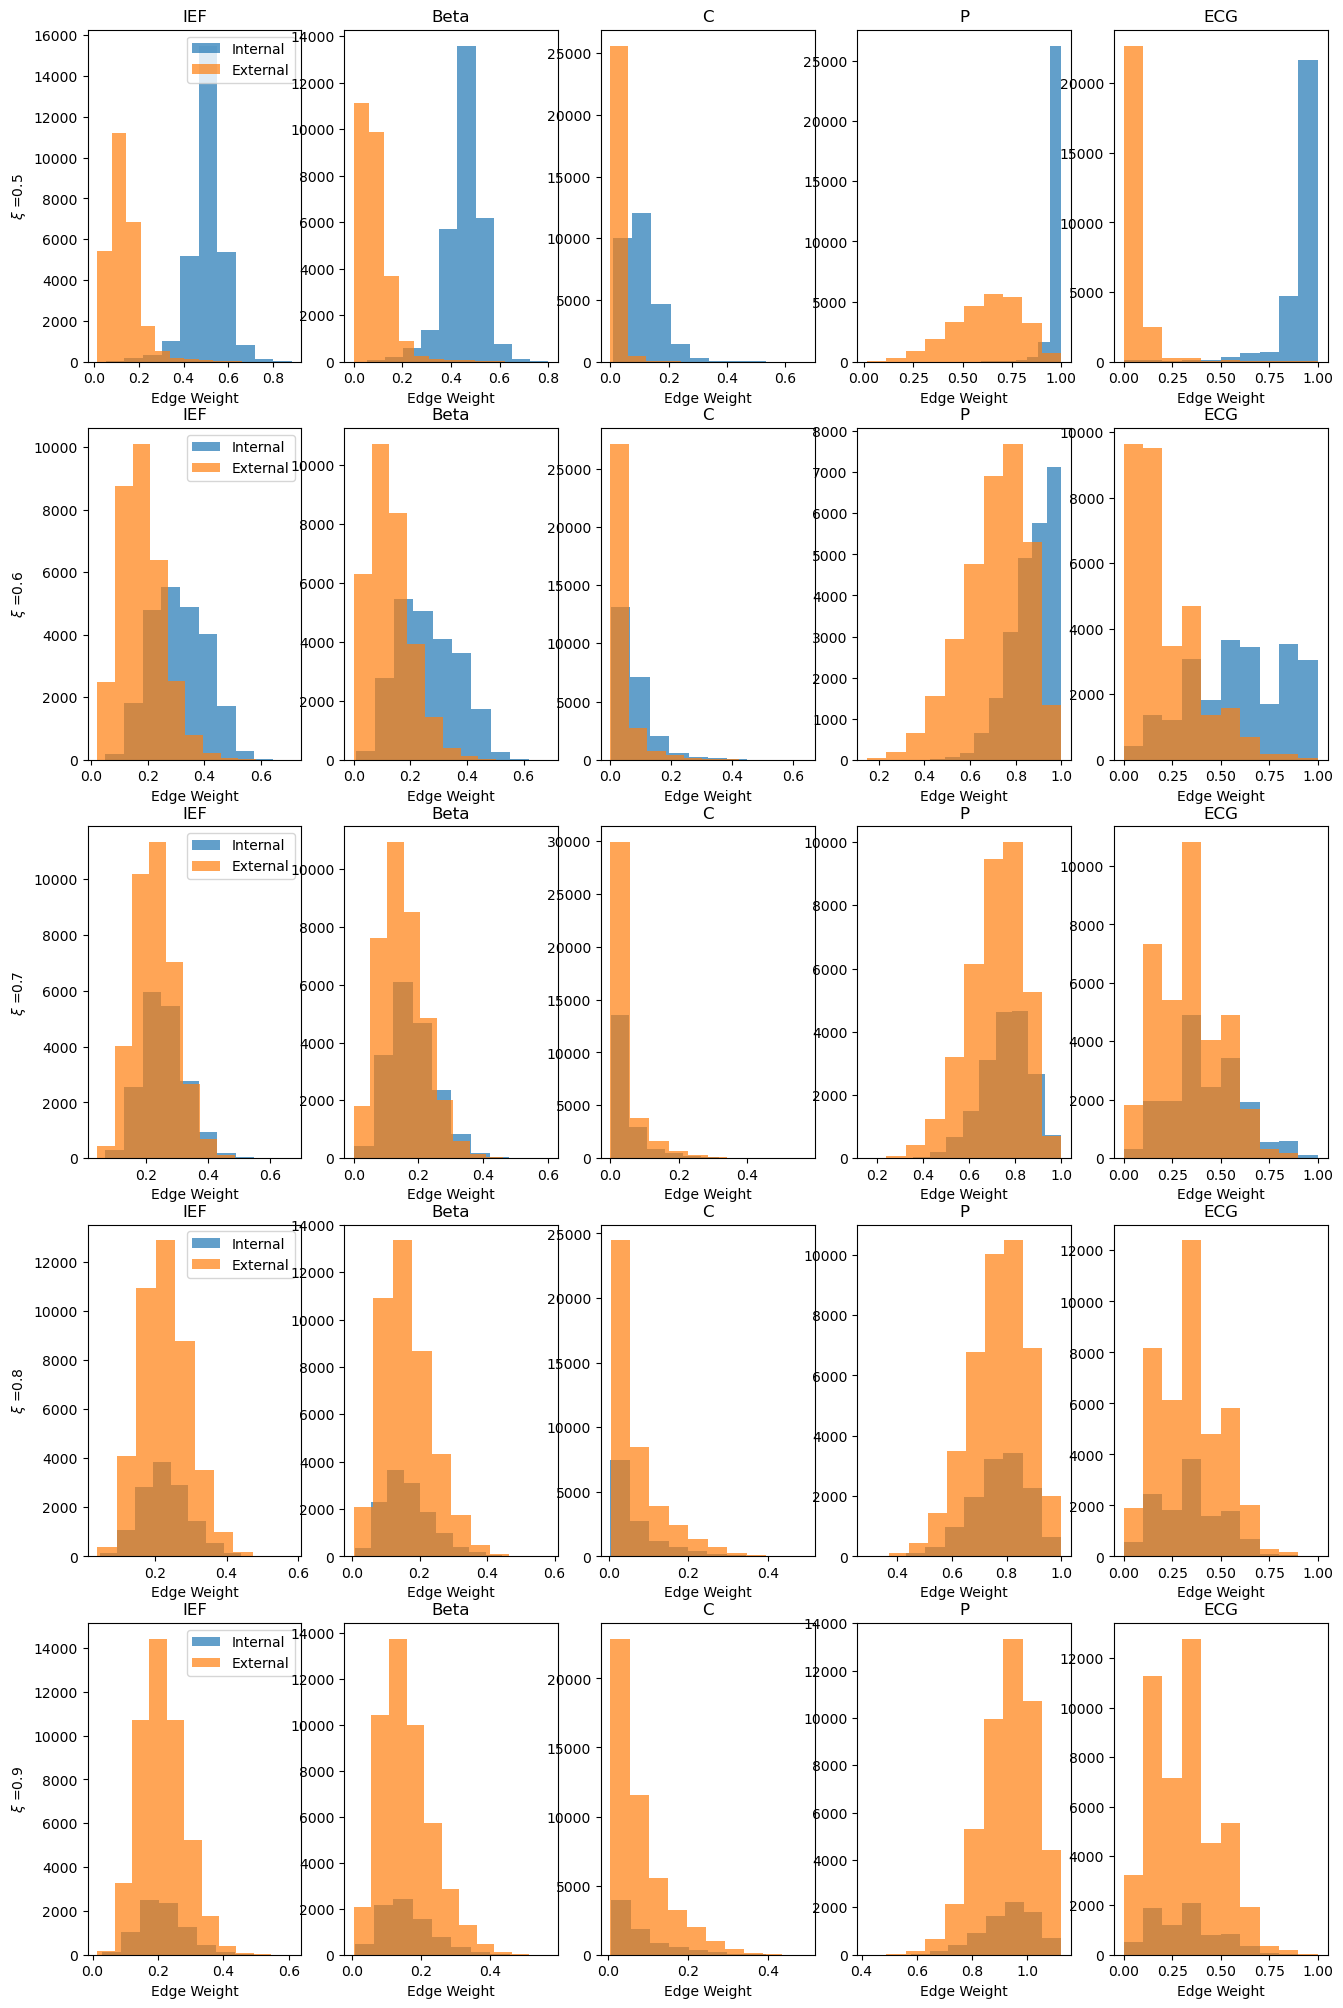

In [35]:
## first with "mid-size" graphs
num_nodes = 10000
num_out = 0
delta = 5
min_comm = 100
alpha = 1


XIs = [.5, .6, .7, .8, .9]
fig, axs = plt.subplots(len(XIs), 5, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    ief, beta, c, p, ecg = ensemble_cas_edge_weights(g, combine_function="min", resolution=0.05, clustering_method="first_louvain")
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.7)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel(r'$\xi$ ='+str(xi))

    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 1].hist(beta[is_internal == False], label="External", alpha=0.7)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("Beta")

    axs[i, 2].hist(c[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 2].hist(c[is_internal == False], label="External", alpha=0.7)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title("C")

    axs[i, 3].hist(p[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 3].hist(p[is_internal == False], label="External", alpha=0.7)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"P")

    axs[i, 4].hist(ecg[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 4].hist(ecg[is_internal == False], label="External", alpha=0.7)
    axs[i, 4].set_xlabel("Edge Weight")
    axs[i, 4].set_title(f"ECG")

100%|██████████| 9/9 [15:01<00:00, 100.13s/it]


Text(0.5, 0.98, 'CAS-ECG ground truth ROC curves')

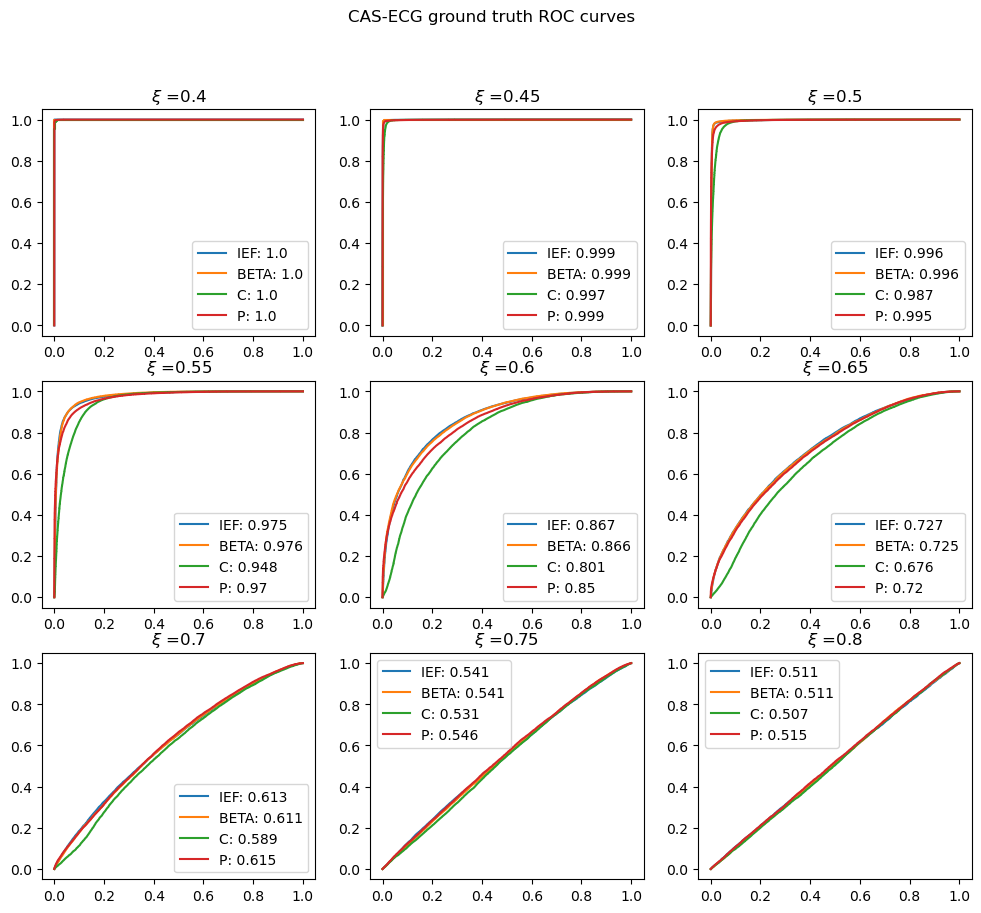

In [ ]:
# ROC curves for edge weight predicting is-internal
XIs = [.4, .45, .5, .55, .6, .65, .7, .75, .8]
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in trange(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    ief, beta, c, p, ecg = ensemble_cas_edge_weights(g, combine_function="min", clustering_method="first_louvain")
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    fpr, tpr, thresholds = roc_curve(is_internal, ief, pos_label=1)
    plt.plot(fpr, tpr, label='IEF: '+str(round(AUC(is_internal, ief),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, beta, pos_label=1)
    plt.plot(fpr, tpr, label='BETA: '+str(round(AUC(is_internal, beta),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, c, pos_label=1)
    plt.plot(fpr, tpr, label='C: '+str(round(AUC(is_internal, c),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, p, pos_label=1)
    plt.plot(fpr, tpr, label='P: '+str(round(AUC(is_internal, p),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, ecg, pos_label=1)
    plt.plot(fpr, tpr, label='ECG: '+str(round(AUC(is_internal, ecg),5)))

    plt.title(r'$\xi$ ='+str(xi))
    plt.legend()
    

plt.suptitle("CAS-ECG ground truth ROC curves")

## A small benchmark for cas-ecg clustering

In [6]:
## first with "mid-size" graphs
REP = 5
num_nodes = 2000
num_out = 0
delta = 5
min_comm = 100
alpha = 1

XIs = [.5, .55, .6, .65, .7]
data = []
pbar = tqdm(total = len(XIs)*REP)
for xi, rep in product(XIs, range(REP)):
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767)

    gt = np.array(g.vs["gt"])
    ief, beta, c, p, ecgw = ecg_igraph.ensemble_cas_edge_weights(g)
    options = [
        ["IEF", ief],
        ["BETA", beta],
        ["C", c],
        ["P", p],
        ["ECG", ecgw]
    ]
    for name, edge_weights in options:
        clustering = ecg_igraph.cluster_edges(g, edge_weights).membership
        data.append([name, xi, AMI(gt, clustering)])
    
    # Include reference ecg implementation
    ref_ecg = g.community_ecg().membership
    data.append(["REF ECG", xi, AMI(gt, ref_ecg)])

    pbar.update()
pbar.close()

100%|██████████| 25/25 [08:52<00:00, 21.30s/it]


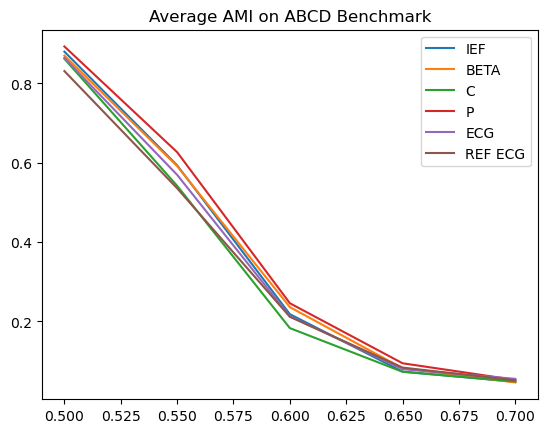

In [7]:
df = pd.DataFrame(data, columns=['name','xi','score'])
D = df.groupby(['name', "xi"])["score"].mean()

for name in df["name"].unique():
    xis = D[name].index.values
    scores = D[name].values
    plt.plot(xis, scores, label=name)
plt.title("Average AMI on ABCD Benchmark")
plt.legend()

In [7]:
g = _run_julia_abcd(n=2000, xi=0.5)
adj = g.get_adjacency_sparse()

ief_ig, beta_ig, c_ig, p_ig, ecg_ig = ensemble_cas_edge_weights(g, ens_size=32)
ief_sn, beta_sn, c_sn, p_sn, ecg_sn = ecg.ensemble_cas_edge_weights(adj, ens_size=32)

In [8]:
ecg_ref = g.community_ecg(ens_size=32)

(array([2642.,  781.,  614.,  579.,  642.,  896.,  693.,  594.,  683.,
        1459.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

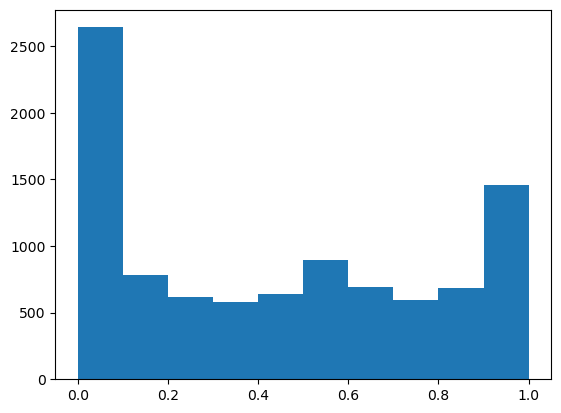

In [9]:
plt.hist(ecg_ig)

(array([1.8427e+04, 5.0800e+02, 8.3000e+01, 3.9000e+01, 2.0000e+01,
        2.0000e+01, 1.3000e+01, 2.3000e+01, 2.2000e+01, 1.1000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

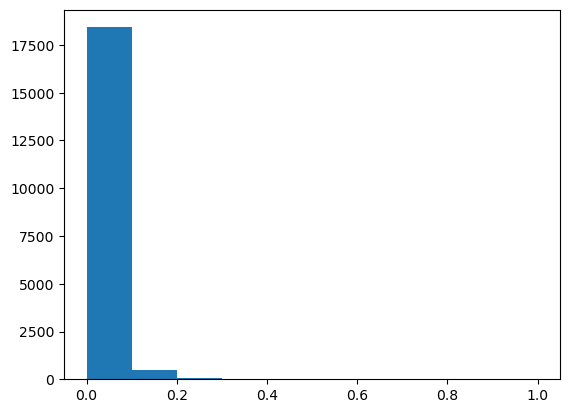

In [10]:
plt.hist(ecg_sn)

In [379]:
import sknetwork as sn

method = sn.clustering.Leiden(n_aggregations=1, shuffle_nodes=True, resolution=1, modularity="Newman")
x = method.fit_predict(adj)

permutation = np.random.permutation(adj.shape[0])
temp = adj[permutation][:, permutation]
tc = method.fit_predict(temp)

inverse_permutation = np.empty_like(permutation)
inverse_permutation[permutation] = np.arange(len(permutation))
y = tc[inverse_permutation]

print(f"Similarity AMI: {AMI(x, y)}")
print(f"Similarity x to gt {AMI(g.vs['gt'], x)}")
print(f"Similarity y to gt {AMI(g.vs['gt'], y)}")

print(f"x has {np.max(x)+1} clusters")
print(f"y has {np.max(y)+1} clusters")

Similarity AMI: 0.39024628266701983
Similarity x to gt 0.4998884307110651
Similarity y to gt 0.4698118061483828
x has 161 clusters
y has 154 clusters


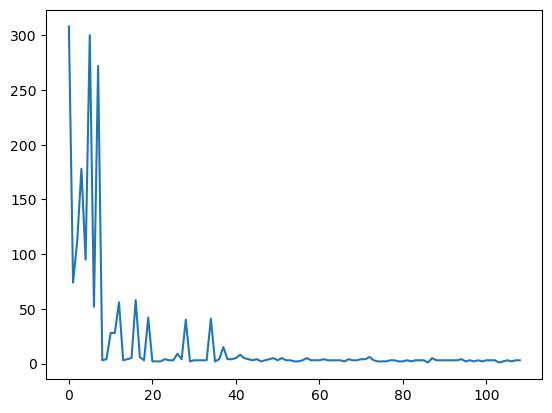

In [338]:
from collections import Counter
z = list(Counter(x).values())
plt.plot(range(len(z)), z)

In [408]:
x = np.array(g.community_leiden(n_iterations=1, resolution=8, objective_function="modularity").membership)
permutation = np.random.permutation(g.vcount())
G = g.permute_vertices(permutation)
tc = np.array(G.community_leiden(n_iterations=1, resolution=8, objective_function="modularity").membership)
inverse_permutation = np.empty_like(permutation)
inverse_permutation[permutation] = np.arange(len(permutation))
y = tc[inverse_permutation]

print(f"Similarity AMI: {AMI(x[permutation], tc)}")
print(f"Similarity x to gt {AMI(np.array(g.vs['gt'])[permutation], x[permutation])}")
print(f"Similarity y to gt {AMI(G.vs['gt'], tc)}")

print(f"x has {np.max(x)+1} clusters")
print(f"y has {np.max(y)+1} clusters")

Similarity AMI: -0.004387526828643332
Similarity x to gt 0.36952472957340776
Similarity y to gt 0.36349188123571996
x has 147 clusters
y has 149 clusters


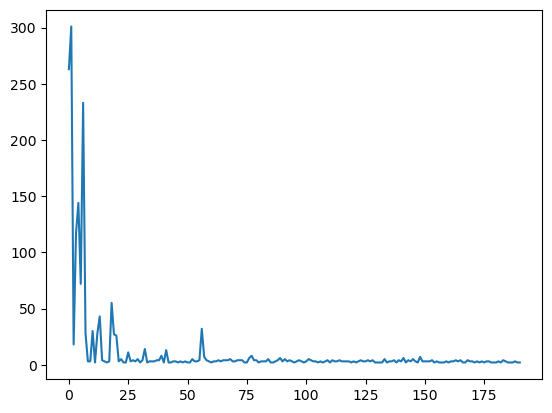

In [281]:
z = list(Counter(x).values())
plt.plot(range(len(z)), z)

In [93]:
i = 1
print(f"Edge {i}: {g.es[i].source} <-> {g.es[i].target}")

print(f"Edge {i}: {G.es[i].source} <-> {G.es[i].target}")
print(f"Permutation {permutation[g.es[i].source]} <-> {permutation[g.es[i].target]}")

Edge 1: 0 <-> 2
Edge 1: 1522 <-> 1744
Permutation 1522 <-> 1744


In [209]:
%%timeit
x = adj[permutation][:, permutation]

157 μs ± 1.74 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [197]:
old = adj.indices[adj.indptr[1]:adj.indptr[2]]
old

array([ 0,  6,  7, 11, 12, 28, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82], dtype=int32)

In [ ]:
permutation

np.int64(1063)

In [231]:
x = np.empty_like(permutation)
x[permutation] = np.arange(len(x))

In [234]:
permutation[x]

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [201]:
new_ind = 1075
new = x.indices[x.indptr[new_ind]:x.indptr[new_ind+1]]
new

array([ 328,   20, 1955,  741,   61,  119, 1552,  408,   82, 1460, 1603,
        111, 1851,  815,  424, 1274,  659,  938, 1907, 1994, 1812, 1727,
       1509, 1929, 1101,   98, 1983,  795,  993,  601,  251, 1302, 1534,
       1958,  545, 1513,  886,  673,  910, 1702,  685, 1221, 1172,  471],
      dtype=int32)

In [202]:
permutation[new]

array([ 0,  6,  7, 11, 12, 28, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

(array([2243.,  985.,  714.,  765.,  689., 1052.,  674.,  591.,  594.,
        1276.]),
 array([0.05 , 0.145, 0.24 , 0.335, 0.43 , 0.525, 0.62 , 0.715, 0.81 ,
        0.905, 1.   ]),
 <BarContainer object of 10 artists>)

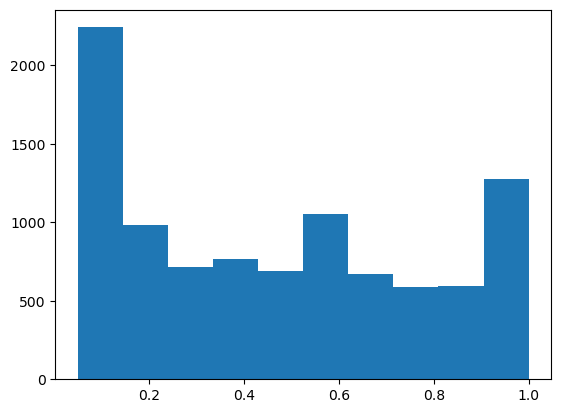

In [102]:
plt.hist(ecg_ref.W)

In [21]:
np.sum(WG.data == 0.05)

np.int64(738)

In [41]:
beta_ig

array([0.45332235, 0.4439733 , 0.01538719, ..., 0.34788107, 0.45587364,
       0.1843766 ])

In [42]:
G = g
edge_weights = beta_ig

if min_weight > 0:
    edge_weights = (1-min_weight) * edge_weights + min_weight

if twocore:
    core = G.shell_index()
    ecore = np.array([min(core[e.source],core[e.target]) for e in G.es])
    edge_weights[ecore == 1] = min_weight

In [43]:
edge_weights

array([0.48065623, 0.47177463, 0.06461783, ..., 0.38048702, 0.48307996,
       0.22515777])

In [11]:
ig_edge_weights = ief_ig
sn_edge_weigths = np.empty(len(ig_edge_weights))
for i, e in enumerate(g.es):
    sn_edge_weigths[i] = ief_sn[e.source, e.target]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Refuse to Cluster Scores

100%|██████████| 16/16 [03:36<00:00, 13.51s/it]


Text(0.5, 0.98, 'Overall outlier scores')

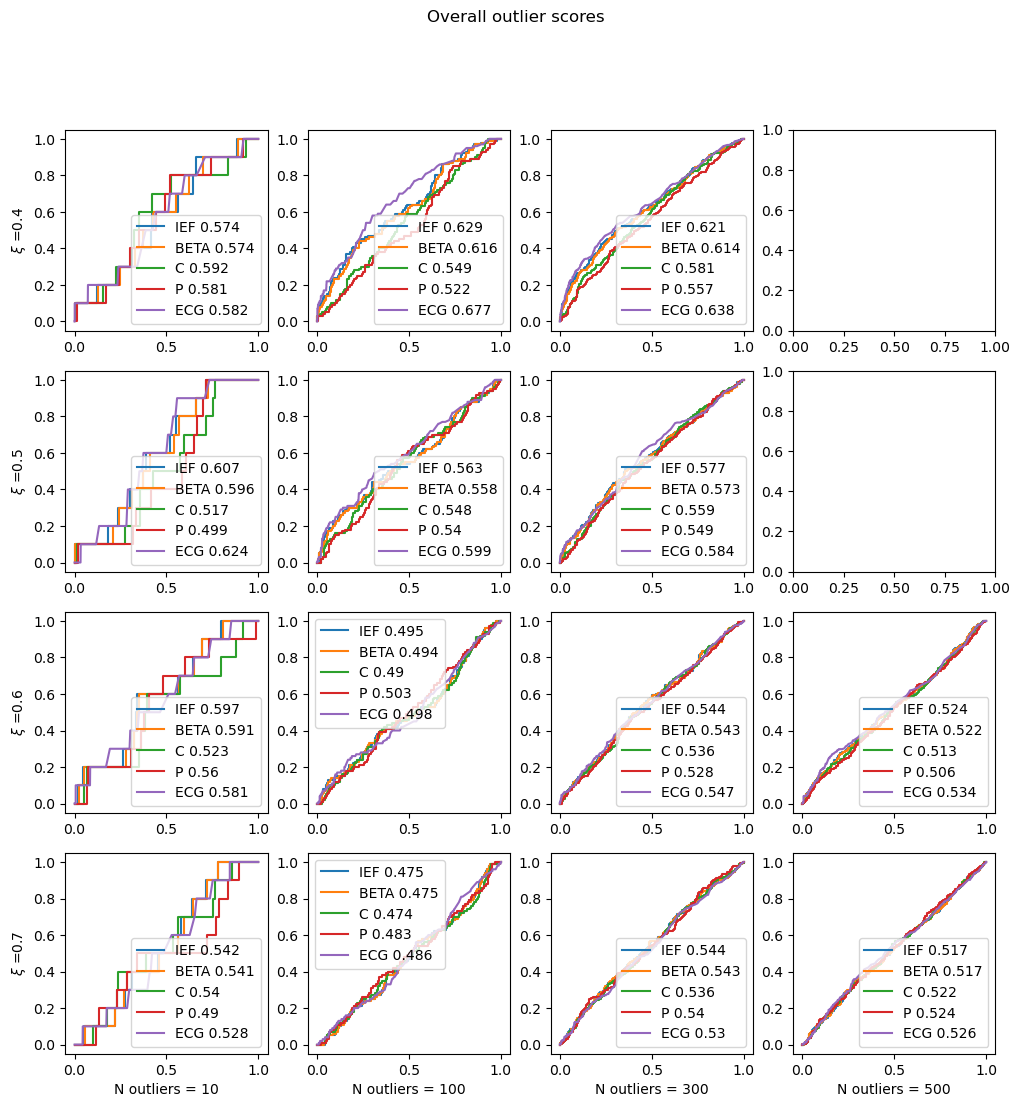

In [55]:
## first with "mid-size" graphs
num_nodes = 1000
num_out = 0
delta = 5
min_comm = 100
alpha = 1

XIs = [.4, .5, .6, .7]
pouts = [.01, .1, .3, .5]
fig, axs = plt.subplots(len(XIs), len(pouts), figsize=(12, 12))
for i in trange(len(XIs)*len(pouts)):
    row = i//len(XIs)
    col = i%len(pouts)

    if XIs[row] <= pouts[col]:
        continue

    xi = XIs[row]
    n_out = int(pouts[col]*num_nodes)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=n_out)
    ief, beta, c, p, ecg = ensemble_cas_edge_weights(g)

    is_outlier = np.array(g.vs["gt"]) == 0

    options = [
        [ief, "IEF "],
        [beta, "BETA "],
        [c, "C "],
        [p, "P "],
        [ecg, "ECG "]
    ]
    for edge_weights, name in options:
        clustering = cluster_edges(g, edge_weights).membership
        outlier_score, _ = outlier_scores(g, edge_weights, clustering)
        fpr, tpr, thresholds = roc_curve(is_outlier, outlier_score, pos_label=1)
        axs[row, col].plot(fpr, tpr, label=name+str(round(AUC(is_outlier, outlier_score),3)))
    axs[row, col].legend()
    if row == len(XIs)-1:
        axs[row, col].set_xlabel(f"N outliers = "+str(n_out))
    if col == 0:
        axs[row, col].set_ylabel(r'$\xi$ =' +str(xi))
plt.suptitle("Overall outlier scores")


100%|██████████| 16/16 [04:02<00:00, 15.18s/it]


Text(0.5, 0.98, 'Community outlier scores')

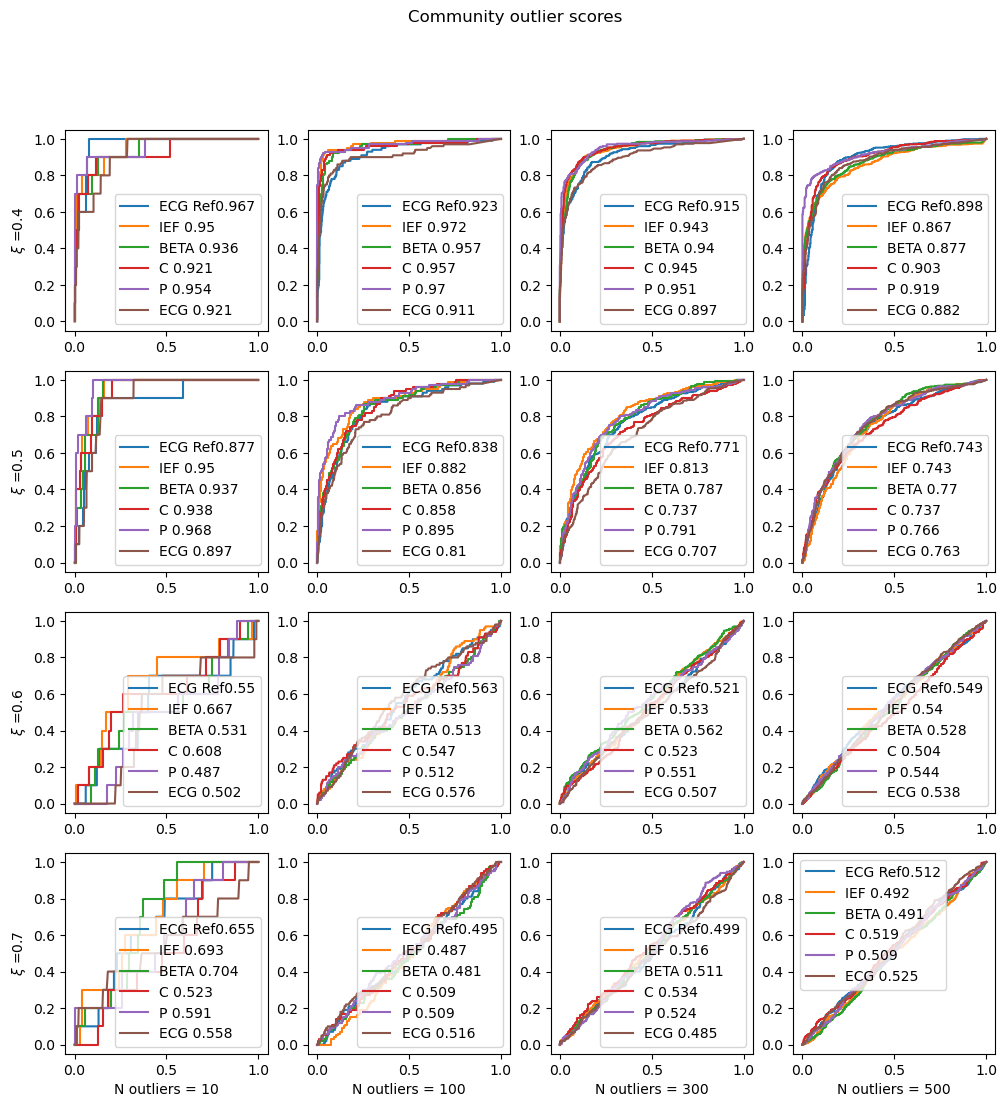

In [64]:
## first with "mid-size" graphs
num_nodes = 1000
num_out = 0
delta = 5
min_comm = 100
alpha = 1

XIs = [.4, .5, .6, .7]
pouts = [.01, .1, .3, .5]
fig, axs = plt.subplots(len(XIs), len(pouts), figsize=(12, 12))
for i in trange(len(XIs)*len(pouts)):
    row = i//len(XIs)
    col = i%len(pouts)
    xi = XIs[row]
    n_out = int(pouts[col]*num_nodes)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=n_out)
    ief, beta, c, p, ecg = ensemble_cas_edge_weights(g)

    is_outlier = np.array(g.vs["gt"]) == 0
    ecg_ref = g.community_ecg(refuse_score=True)
    clustering = ecg_ref.membership

    fpr, tpr, thresholds = roc_curve(is_outlier, ecg_ref.refuse_community, pos_label=1)
    axs[row, col].plot(fpr, tpr, label="ECG Ref"+str(round(AUC(is_outlier, ecg_ref.refuse_community),3)))
    
    options = [
        [ief, "IEF "],
        [beta, "BETA "],
        [c, "C "],
        [p, "P "],
        [ecg, "ECG "]
    ]
    for edge_weights, name in options:
        clustering = cluster_edges(g, edge_weights).membership
        _, outlier_score = outlier_scores(g, edge_weights, clustering)
        fpr, tpr, thresholds = roc_curve(is_outlier, outlier_score, pos_label=1)
        axs[row, col].plot(fpr, tpr, label=name+str(round(AUC(is_outlier, outlier_score),3)))
    axs[row, col].legend()
    if row == len(XIs)-1:
        axs[row, col].set_xlabel(f"N outliers = "+str(n_out))
    if col == 0:
        axs[row, col].set_ylabel(r'$\xi$ =' +str(xi))
plt.suptitle("Community outlier scores")

# A more comprehensive benchmark

To generate data, run the script ```benchmark.py```. It will likely take several hours.

In [ ]:
df = pd.read_feather("ecg_benchmarks.feather")
D = df.groupby(by=["name", "n_out", "task", "xi"])['score'].mean()
df["task"].unique()

In [ ]:
# Normalize plotting
def plot_task(task, D, ref="ECG", score="AUC"):
    n_outs = df["n_out"].unique()
    fig, axs = plt.subplots(1, len(n_outs), figsize=(20, 4))
    for name in ["BETA", "P", "C", "IEF", "ECG"]:
        for i, n_out in enumerate(n_outs):
            xis = D[name][n_out][task].index.values
            vals = D[name][n_out][task].values

            if ref is not None:
                ref_vals = D[ref][n_out][task].values
                vals = (vals-ref_vals)

            # chance = 0.5 if score == "AUC" else 0
            # bin_width = xis[1]-xis[0]
            # area_above_chance = np.sum((vals-chance)*bin_width) / ((1 - chance) * len(vals) * bin_width)
            # area_above_chance is a percentage of the area above the AUC=0.5 line out of the total possible area (where AUC is always 1)

            axs[i].plot(xis, vals, label=f"{name}")
            axs[i].legend()
            axs[i].set_xlabel(f"nout = {n_out}")
    axs[0].set_ylabel(score)
    plt.suptitle(task)

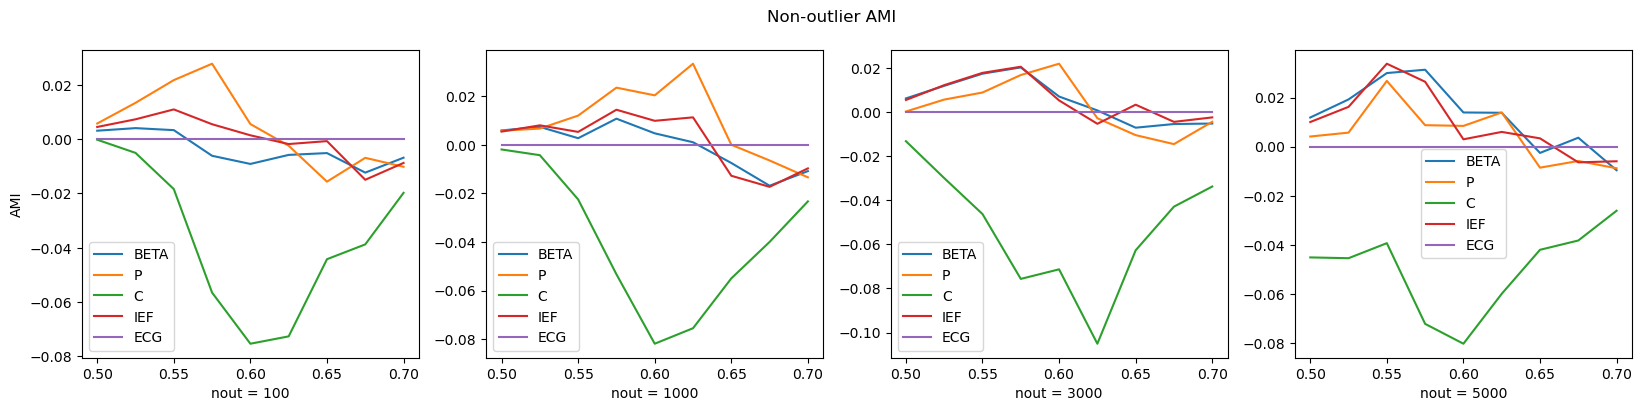

In [33]:
task = "Non-outlier AMI"
plot_task(task, D, score="AMI", ref="ECG")

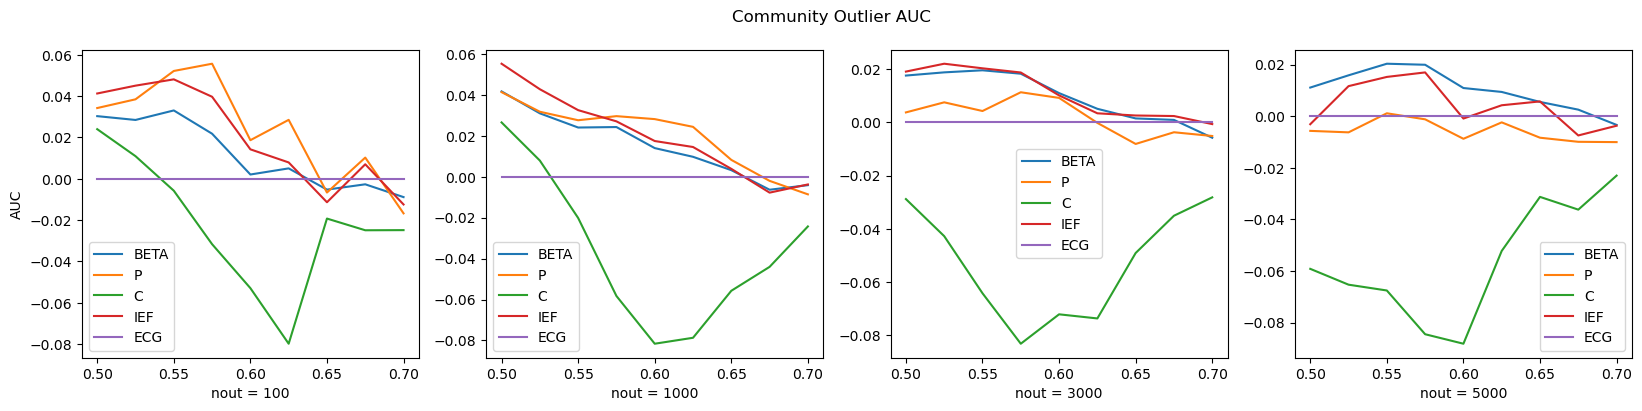

In [24]:
task = "Community Outlier AUC"
plot_task(task, D, ref="ECG")

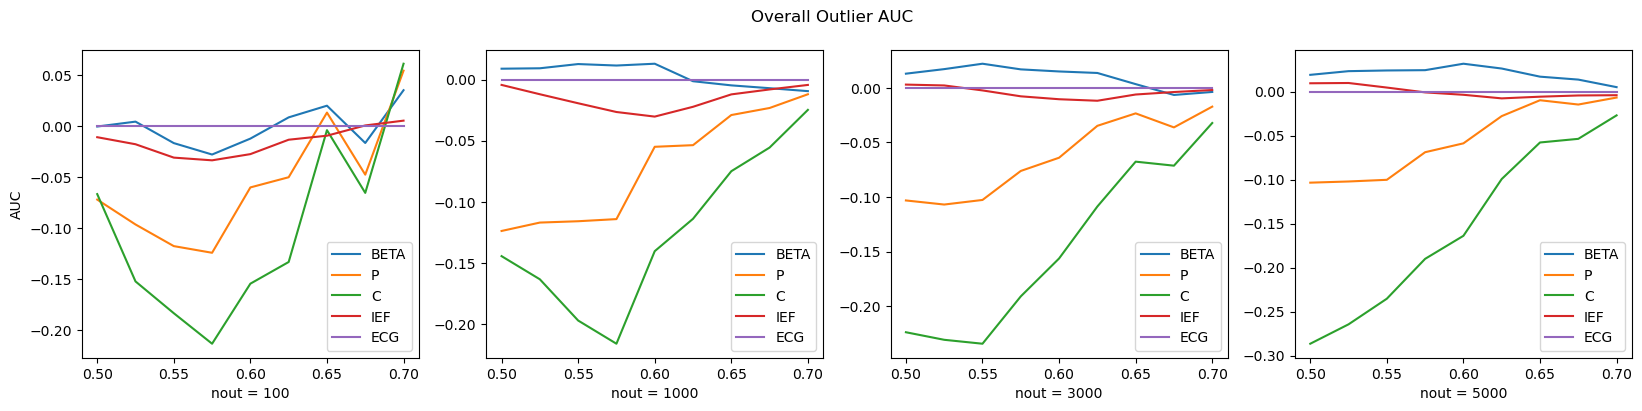

In [25]:
task = "Overall Outlier AUC"
plot_task(task, D, ref="ECG")

## CAS Outlier AUC's were backwards, so lower is actually better

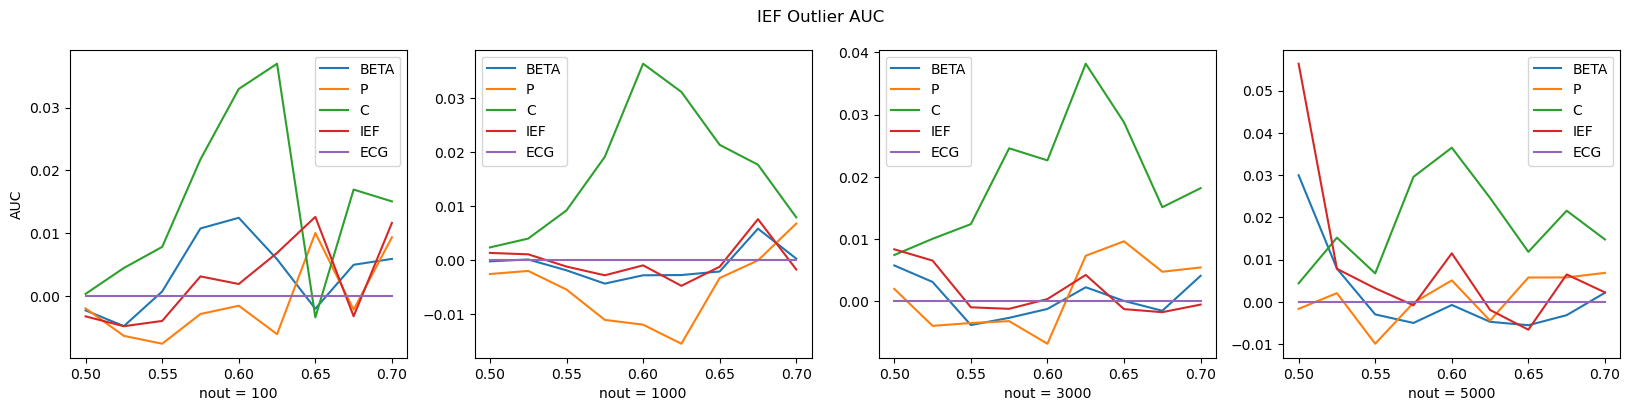

In [28]:
task = "IEF Outlier AUC"
plot_task(task, D, ref="ECG")

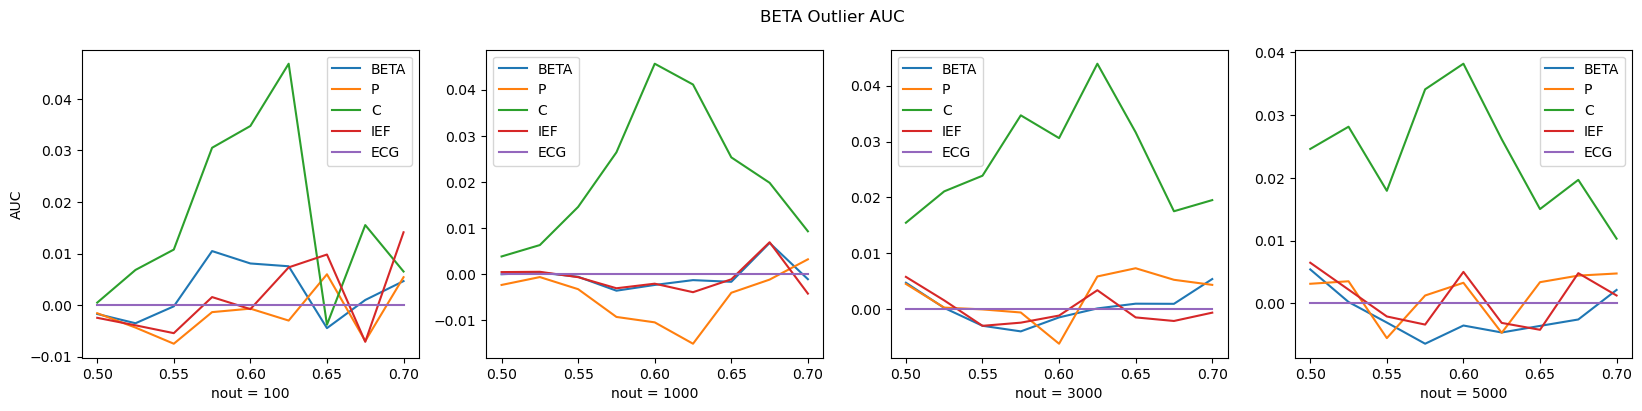

In [29]:
task = "BETA Outlier AUC"
plot_task(task, D, ref="ECG")

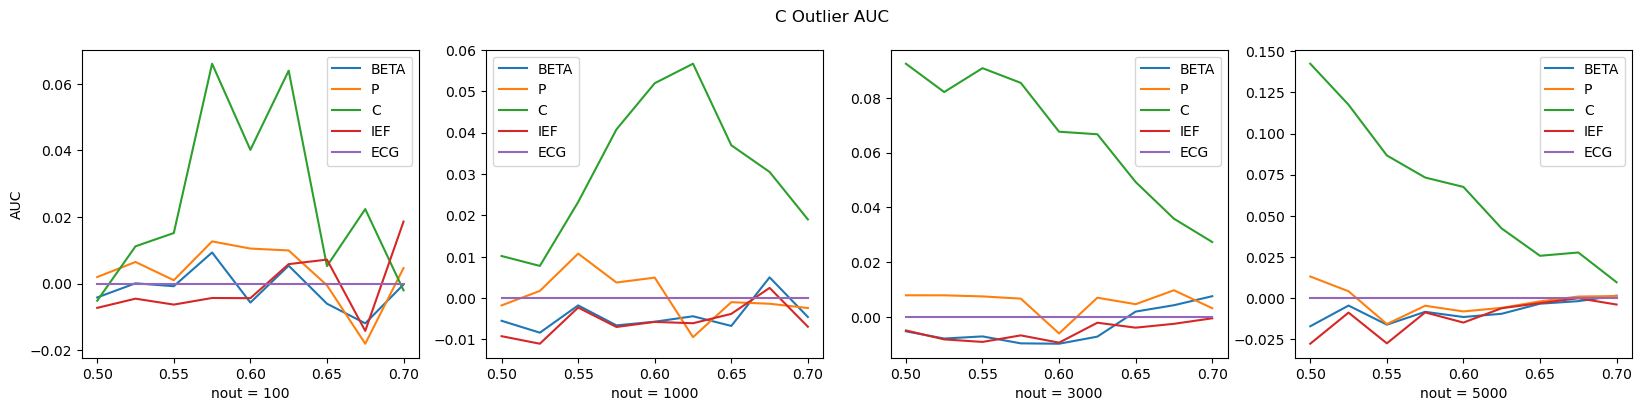

In [30]:
task = "C Outlier AUC"
plot_task(task, D, ref="ECG")


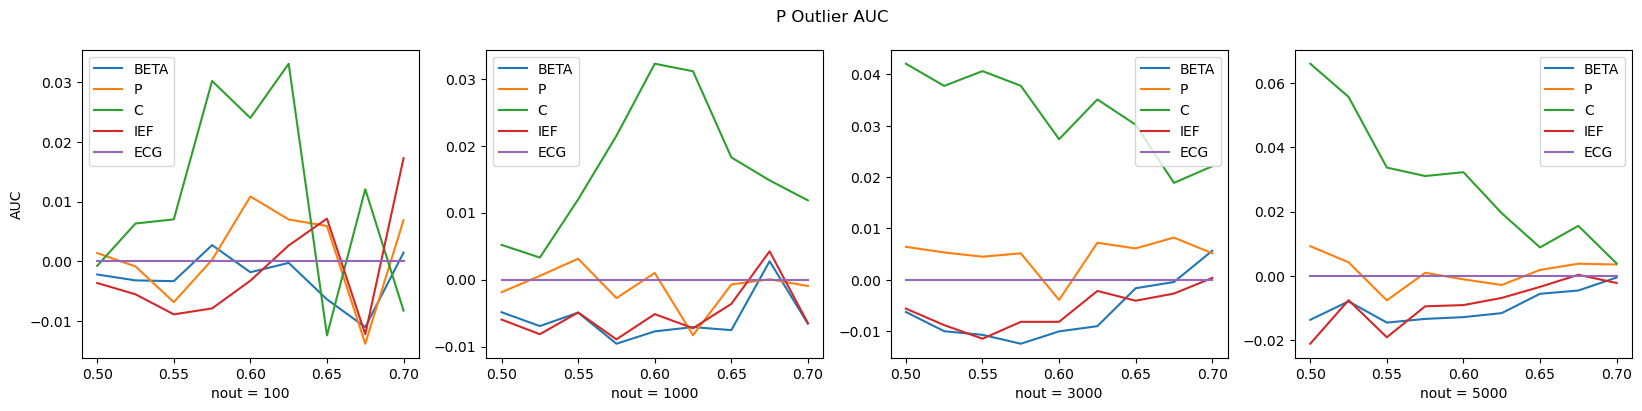

In [31]:
task = "P Outlier AUC"
plot_task(task, D, ref="ECG")